## Get & Clean Data

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.formula.api import ols

In [7]:
%matplotlib inline

## Clean Data

In [54]:
# Download data
data = yf.download("BA SPY", start="2020-03-31", end="2020-10-01")

[*********************100%***********************]  2 of 2 completed


In [89]:
# Select adjusted close and rename column
stocks = data['Adj Close'].copy()

# Calculate data from prices
for col in stocks.columns:
    # Daily Returns
    stocks[f'{col}_daily_ret'] = stocks[col].diff(1)
    
    # Max-min normalized price
    stocks[f'{col}_max_min_norm_price'] = (stocks[col] - stocks[col].min()) / (stocks[col].max() - stocks[col].min())
    
    # Max-min normalized daily return
    stocks[f'{col}_max_min_norm_daily_ret'] = (stocks[f'{col}_daily_ret'] - stocks[f'{col}_daily_ret'].min()) / (stocks[f'{col}_daily_ret'].max() - stocks[f'{col}_daily_ret'].min())

    # Starting value normalization
    stocks[f'{col}_start_val_norm_price'] = stocks[col].div(stocks[col].iloc[0]).mul(100)
    stocks[f'{col}_start_val_norm_daily_ret'] = stocks[f'{col}_daily_ret'].div(stocks[f'{col}_daily_ret'].iloc[1]).mul(100)
    
    # Smooth returns with 7 day rolling average for normalized daily returns
    stocks[f'{col}_7d_rolling_avg_max_min_daily_ret'] = stocks[f'{col}_max_min_norm_daily_ret'].rolling(window=7).mean()
    stocks[f'{col}_7d_rolling_avg_start_val_norm_price'] = stocks[f'{col}_start_val_norm_price'].rolling(window=7).mean()
    stocks[f'{col}_7d_rolling_avg_start_val_norm_ret'] = stocks[f'{col}_start_val_norm_daily_ret'].rolling(window=7).mean()

print(stocks.shape)

stocks.head()

(128, 18)


,BA,SPY,BA_daily_ret,BA_max_min_norm_price,BA_max_min_norm_daily_ret,BA_start_val_norm_price,BA_start_val_norm_daily_ret,BA_7d_rolling_avg_max_min_daily_ret,BA_7d_rolling_avg_start_val_norm_price,BA_7d_rolling_avg_start_val_norm_ret,SPY_daily_ret,SPY_max_min_norm_price,SPY_max_min_norm_daily_ret,SPY_start_val_norm_price,SPY_start_val_norm_daily_ret,SPY_7d_rolling_avg_max_min_daily_ret,SPY_7d_rolling_avg_start_val_norm_price,SPY_7d_rolling_avg_start_val_norm_ret
Date,,,,,,,,,,,,,,,,,,
2020-03-31,149.139999,255.597580,NaN,0.263710,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,0.102542,NaN,100.000000,NaN,NaN,NaN,NaN
2020-04-01,130.699997,244.094437,-18.440002,0.096833,0.255985,87.635777,100.000000,NaN,NaN,NaN,-11.503143,0.000000,0.193668,95.499510,100.000000,NaN,NaN,NaN
2020-04-02,123.269997,249.727020,-7.430000,0.029593,0.444254,82.653880,40.292838,NaN,NaN,NaN,5.632584,0.050210,0.686538,97.703202,-48.965604,NaN,NaN,NaN
2020-04-03,124.519997,246.117416,1.250000,0.040905,0.592681,83.492019,-6.778741,NaN,NaN,NaN,-3.609604,0.018033,0.420708,96.290981,31.379283,NaN,NaN,NaN
2020-04-06,148.770004,262.648193,24.250008,0.260362,0.985978,99.751914,-131.507616,NaN,NaN,NaN,16.530777,0.165394,1.000000,102.758482,-143.706607,NaN,NaN,NaN


In [69]:
# Load COVID Data

df = pd.read_csv('all-states-history.csv', parse_dates=True, index_col=0)

In [80]:
df = df.groupby('date').sum()[['death', 'positive']]

df = df.loc['2020-03-31': '2020-10-01']

# Difference from previous day
for col in df.columns:
    # Daily differences
    df[f'daily_{col}'] = df[col].diff(1)
    
    # Normalized
    df[f'max_min_norm_{col}'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    df[f'max_min_norm_daily_{col}'] = (df[f'daily_{col}'] - df[f'daily_{col}'].min()) / (df[f'daily_{col}'].max() - df[f'daily_{col}'].min())
    
    df[f'start_val_norm_daily_{col}'] = df[f'daily_{col}'].div(df[f'daily_{col}'].iloc[1]).mul(100)
    
    # Norm Rolling
    df[f'7d_rolling_avg_max_min_daily_{col}'] = df[f'max_min_norm_daily_{col}'].rolling(window=7).mean()
    df[f'7d_rolling_avg_start_val_daily_{col}'] = df[f'start_val_norm_daily_{col}'].rolling(window=7).mean()

df

,death,positive,daily_death,max_min_norm_death,max_min_norm_daily_death,start_val_norm_daily_death,7d_rolling_avg_max_min_daily_death,7d_rolling_avg_start_val_daily_death,daily_positive,max_min_norm_positive,max_min_norm_daily_positive,start_val_norm_daily_positive,7d_rolling_avg_max_min_daily_positive,7d_rolling_avg_start_val_daily_positive
date,,,,,,,,,,,,,,
2020-03-31,4313.0,198295.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2020-04-01,5324.0,224086.0,1011.0,0.005172,0.315376,100.000000,NaN,NaN,25791.0,0.003660,0.149391,100.000000,NaN,NaN
2020-04-02,6496.0,252146.0,1172.0,0.011168,0.378687,115.924827,NaN,NaN,28060.0,0.007643,0.187197,108.797643,NaN,NaN
2020-04-03,7782.0,284222.0,1286.0,0.017748,0.423516,127.200791,NaN,NaN,32076.0,0.012195,0.254111,124.368966,NaN,NaN
2020-04-04,9264.0,317434.0,1482.0,0.025330,0.500590,146.587537,NaN,NaN,33212.0,0.016908,0.273039,128.773603,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,196868.0,7080906.0,307.0,0.985123,0.038537,30.365974,0.212235,74.056804,35454.0,0.976783,0.310395,137.466558,0.457754,171.757590
2020-09-28,197125.0,7117430.0,257.0,0.986437,0.018875,25.420376,0.210550,73.632895,36524.0,0.981967,0.328224,141.615292,0.450737,170.124684
2020-09-29,197864.0,7154377.0,739.0,0.990218,0.208415,73.095945,0.204090,72.007913,36947.0,0.987210,0.335272,143.255399,0.421002,163.205326


## Visualize Data

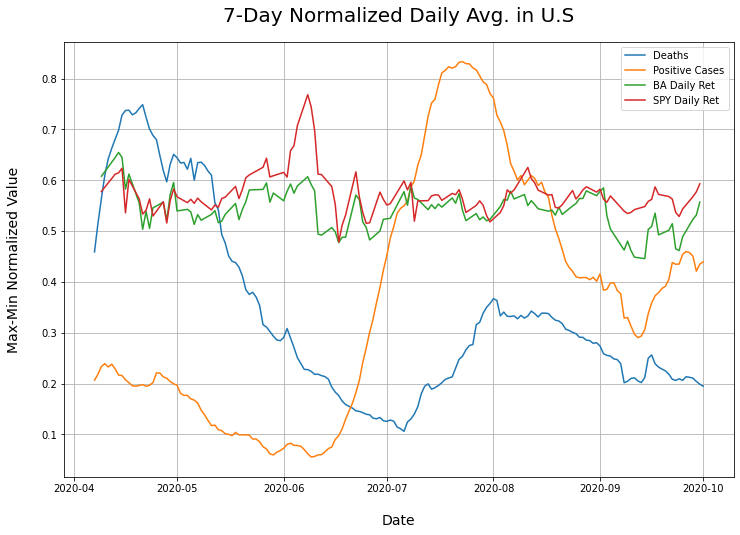

In [74]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot()

ax.plot('7d_rolling_avg_max_min_daily_death', data=df, label='Deaths')
ax.plot('7d_rolling_avg_max_min_daily_positive', data=df, label='Positive Cases')

ax.plot('SPY_7d_rolling_avg_max_min_daily_ret', data=stocks, label='BA Daily Ret')
ax.plot('BA_7d_rolling_avg_max_min_daily_ret', data=stocks, label='SPY Daily Ret')

ax.set_title('7-Day Normalized Daily Avg. in U.S', fontsize=20, pad=20)
ax.set_xlabel('Date', fontsize=14, labelpad=20)
ax.set_ylabel('Max-Min Normalized Value', fontsize=14, labelpad=20)


ax.legend()

ax.grid()

plt.show();

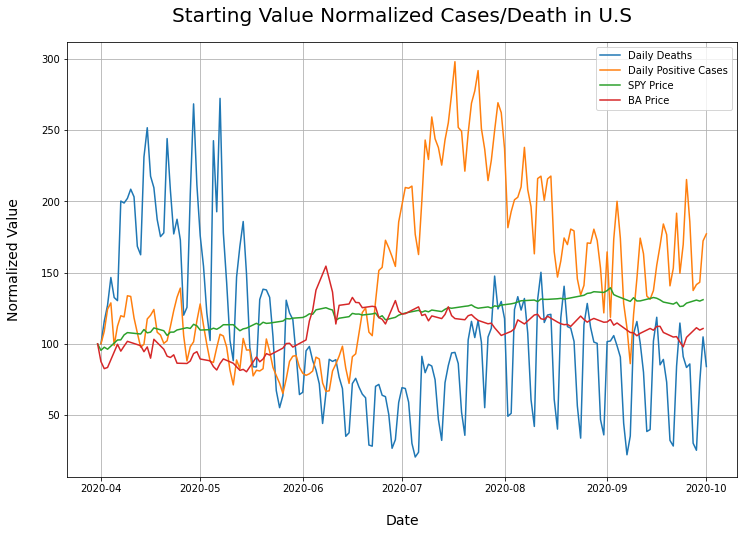

In [75]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot()

ax.plot('start_val_norm_daily_death', data=df, label='Daily Deaths')
ax.plot('start_val_norm_daily_positive', data = df, label='Daily Positive Cases')

ax.plot('SPY_start_val_norm_price', data=stocks, label='SPY Price')
ax.plot('BA_start_val_norm_price', data=stocks, label='BA Price')

ax.set_title('Starting Value Normalized Cases/Death in U.S', fontsize=20, pad=20)
ax.set_xlabel('Date', fontsize=14, labelpad=20)
ax.set_ylabel('Normalized Value', fontsize=14, labelpad=20)

ax.legend()

ax.grid()

plt.show();

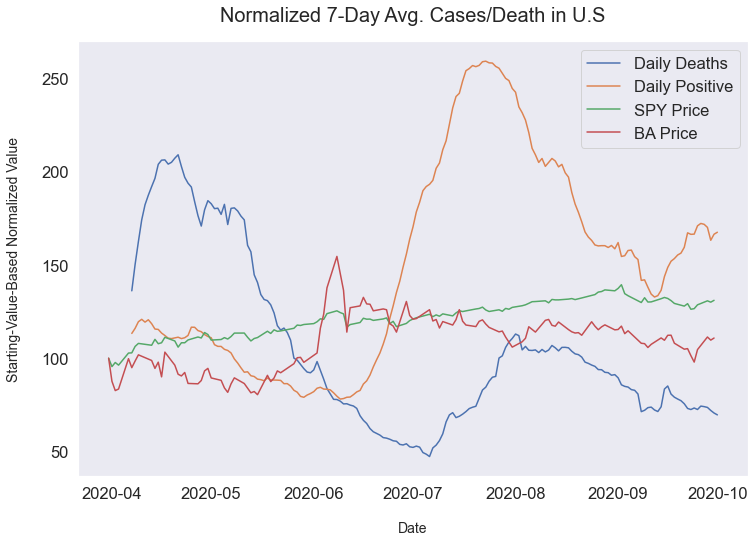

In [139]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot()

ax.plot('7d_rolling_avg_start_val_daily_death', data=df, label='Daily Deaths')
ax.plot('7d_rolling_avg_start_val_daily_positive', data=df, label='Daily Positive')

ax.plot('SPY_start_val_norm_price', data=stocks, label='SPY Price')
ax.plot('BA_start_val_norm_price', data=stocks, label='BA Price')


ax.set_title('Normalized 7-Day Avg. Cases/Death in U.S', fontsize=20, pad=20)
ax.set_xlabel('Date', fontsize=14, labelpad=20)
ax.set_ylabel('Starting-Value-Based Normalized Value', fontsize=14, labelpad=20)


ax.legend()

plt.grid()
plt.show();

## Further Analysis of Observed Statistics

In [100]:
df2 = pd.concat(
    [stocks[['SPY_start_val_norm_price', 'BA_start_val_norm_price']],
     df[['7d_rolling_avg_start_val_daily_death', '7d_rolling_avg_start_val_daily_positive']]
    ],
    axis=1
)
df2.dropna(inplace=True)
df2

,SPY_start_val_norm_price,BA_start_val_norm_price,7d_rolling_avg_start_val_daily_death,7d_rolling_avg_start_val_daily_positive
2020-04-07,102.863241,94.930939,136.116999,113.287581
2020-04-08,106.316190,98.477937,150.233150,115.993951
2020-04-09,107.934042,101.810377,162.540625,119.562749
2020-04-13,106.948588,98.786377,191.959870,118.493716
2020-04-14,110.102817,94.542041,196.368518,115.632253
...,...,...,...,...
2020-09-24,126.566144,97.928124,73.322029,166.500496
2020-09-25,128.612333,104.619820,72.516603,170.953876
2020-09-28,130.748500,111.358457,73.632895,170.124684
2020-09-29,130.036441,109.695593,72.007913,163.205326


In [101]:
df2.corr()

,SPY_start_val_norm_price,BA_start_val_norm_price,7d_rolling_avg_start_val_daily_death,7d_rolling_avg_start_val_daily_positive
SPY_start_val_norm_price,1.000000,0.592852,-0.669721,0.559206
BA_start_val_norm_price,0.592852,1.000000,-0.748761,0.327001
7d_rolling_avg_start_val_daily_death,-0.669721,-0.748761,1.000000,-0.343445
7d_rolling_avg_start_val_daily_positive,0.559206,0.327001,-0.343445,1.000000


In [102]:
ba_to_spy = df2.BA_start_val_norm_price.corr(df2.SPY_start_val_norm_price)
ba_to_deaths = df2.BA_start_val_norm_price.corr(df2['7d_rolling_avg_start_val_daily_death'])

print(f'Correlation between BA price and SPY price: {ba_to_spy}')
print(f'Correlation between BA price and 7d deaths average: {ba_to_deaths}')

Correlation between BA price and SPY price: 0.5928522040325875
Correlation between BA price and 7d deaths average: -0.7487613249267285


In [152]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [174]:
plt.style.use('seaborn')

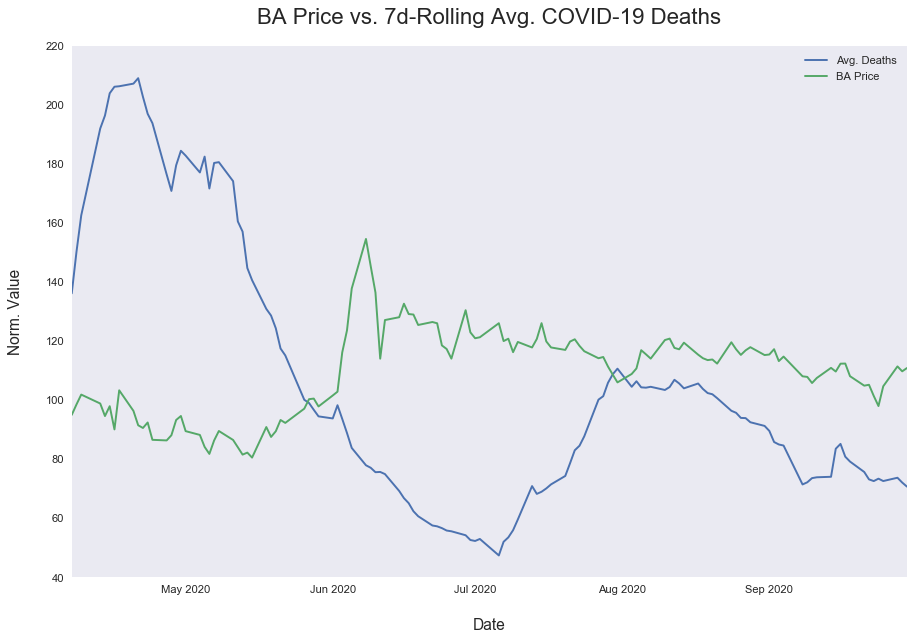

In [176]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot()

ax.plot('7d_rolling_avg_start_val_daily_death', data=df2, label='Avg. Deaths')

# ax.plot('SPY_start_val_norm_price', data=df2, label='SPY Price')
ax.plot('BA_start_val_norm_price', data=df2, label='BA Price')


ax.set_title('BA Price vs. 7d-Rolling Avg. COVID-19 Deaths', fontsize=20, pad=20)
ax.set_xlabel('Date', fontsize=14, labelpad=20)
ax.set_ylabel('Norm. Value', fontsize=14, labelpad=20)

ax.legend()

ax.grid();

plt.savefig('ba_price_avg_deaths_start_val')

plt.show();

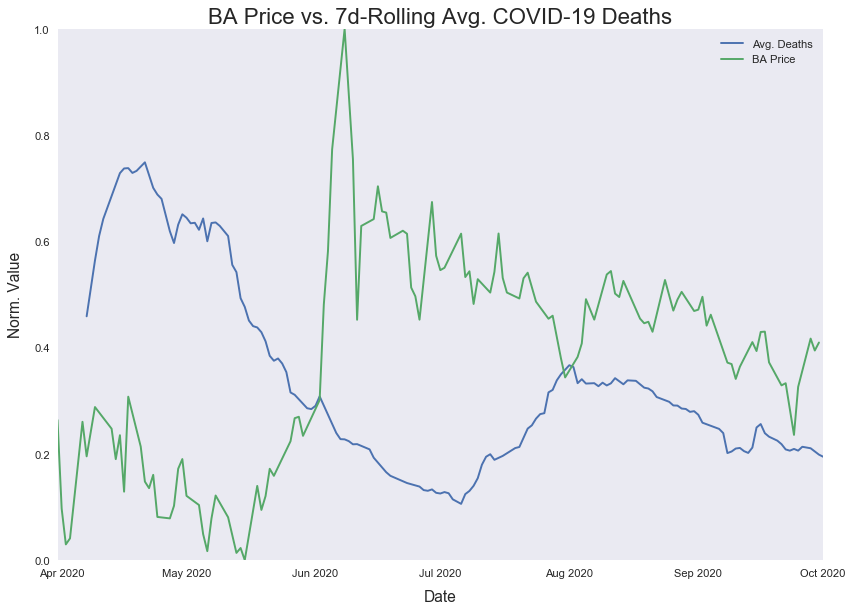

In [182]:
fig = plt.figure(figsize=(11, 8))

ax = fig.add_subplot()

ax.plot('7d_rolling_avg_max_min_daily_death', data=df, label='Avg. Deaths')

# ax.plot('SPY_start_val_norm_price', data=df2, label='SPY Price')
ax.plot('BA_max_min_norm_price', data=stocks, label='BA Price')


ax.set_title('BA Price vs. 7d-Rolling Avg. COVID-19 Deaths', fontsize=20)
ax.set_xlabel('Date', fontsize=14, labelpad=10)
ax.set_ylabel('Norm. Value', fontsize=14, labelpad=10)

ax.legend()

ax.grid();

plt.savefig('ba_price_avg_deaths_max_min')

plt.show();

## Exploring BA Daily Returns to Rolling Death Rate and SPY Price

In [105]:
df2

,SPY_start_val_norm_price,BA_start_val_norm_price,7d_rolling_avg_start_val_daily_death,7d_rolling_avg_start_val_daily_positive
2020-04-07,102.863241,94.930939,136.116999,113.287581
2020-04-08,106.316190,98.477937,150.233150,115.993951
2020-04-09,107.934042,101.810377,162.540625,119.562749
2020-04-13,106.948588,98.786377,191.959870,118.493716
2020-04-14,110.102817,94.542041,196.368518,115.632253
...,...,...,...,...
2020-09-24,126.566144,97.928124,73.322029,166.500496
2020-09-25,128.612333,104.619820,72.516603,170.953876
2020-09-28,130.748500,111.358457,73.632895,170.124684
2020-09-29,130.036441,109.695593,72.007913,163.205326


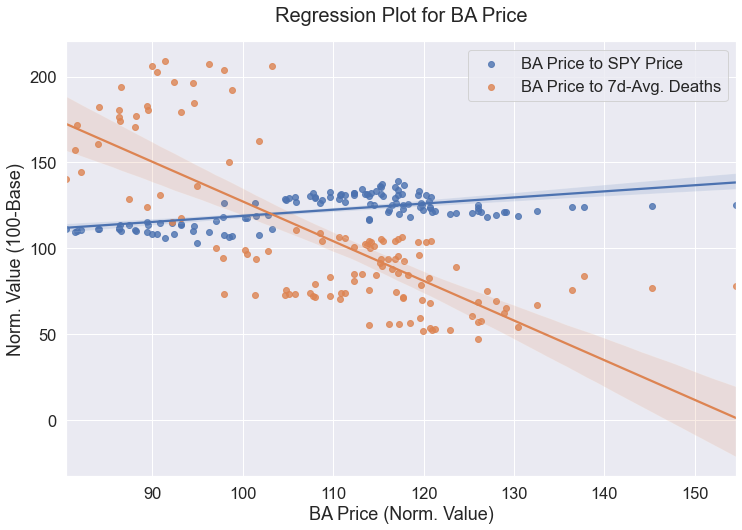

In [115]:
sns.set(font_scale=1.5)

plt.figure(figsize=(12, 8))

sns.regplot(
    'BA_start_val_norm_price',
    'SPY_start_val_norm_price',
    data=df2,
    label='BA Price to SPY Price'
)

sns.regplot(
    'BA_start_val_norm_price',
    '7d_rolling_avg_start_val_daily_death',
    data=df2,
    label='BA Price to 7d-Avg. Deaths'
)

plt.xlabel('BA Price (Norm. Value)')
plt.ylabel('Norm. Value (100-Base)')

plt.title('Regression Plot for BA Price', fontsize=20, pad=20)


plt.legend();

plt.show();

## Ordinary Least Squares Regression

In [124]:
df3 = df2[['SPY_start_val_norm_price', 'BA_start_val_norm_price', '7d_rolling_avg_start_val_daily_death']]

df3.columns = ['SPY_start_val_norm_price', 'BA_start_val_norm_price', 'daily_deaths_7d_rolling_avg_start_val']

In [130]:
results = ols(    
    "BA_start_val_norm_price ~ daily_deaths_7d_rolling_avg_start_val + SPY_start_val_norm_price",
    data=df3
).fit()

print(results.summary())

                               OLS Regression Results                              
Dep. Variable:     BA_start_val_norm_price   R-squared:                       0.576
Model:                                 OLS   Adj. R-squared:                  0.569
Method:                      Least Squares   F-statistic:                     81.44
Date:                     Sun, 04 Oct 2020   Prob (F-statistic):           4.52e-23
Time:                             11:15:58   Log-Likelihood:                -450.45
No. Observations:                      123   AIC:                             906.9
Df Residuals:                          120   BIC:                             915.3
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [184]:
results = ols(    
    "BA_start_val_norm_price ~ daily_deaths_7d_rolling_avg_start_val",
    data=df3
).fit()

print(results.summary())

                               OLS Regression Results                              
Dep. Variable:     BA_start_val_norm_price   R-squared:                       0.561
Model:                                 OLS   Adj. R-squared:                  0.557
Method:                      Least Squares   F-statistic:                     154.4
Date:                     Sun, 04 Oct 2020   Prob (F-statistic):           2.36e-23
Time:                             13:09:28   Log-Likelihood:                -452.61
No. Observations:                      123   AIC:                             909.2
Df Residuals:                          121   BIC:                             914.8
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

<Figure size 640x440 with 0 Axes>

In [132]:
results = ols(    
    "BA_start_val_norm_price ~ SPY_start_val_norm_price",
    data=df3
).fit()

results.summary()

print(results.summary())

                               OLS Regression Results                              
Dep. Variable:     BA_start_val_norm_price   R-squared:                       0.351
Model:                                 OLS   Adj. R-squared:                  0.346
Method:                      Least Squares   F-statistic:                     65.58
Date:                     Sun, 04 Oct 2020   Prob (F-statistic):           5.04e-13
Time:                             11:16:23   Log-Likelihood:                -476.55
No. Observations:                      123   AIC:                             957.1
Df Residuals:                          121   BIC:                             962.7
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

> In statistics, multicollinearity (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. In this situation, the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors. That is, a multivariate regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others.

https://en.wikipedia.org/wiki/Multicollinearity

In [135]:
results.pvalues

Intercept                                3.703085e-92
daily_deaths_7d_rolling_avg_start_val    2.360545e-23
dtype: float64

In [137]:
df.columns

Index(['death', 'positive', 'daily_death', 'max_min_norm_death',
       'max_min_norm_daily_death', 'start_val_norm_daily_death',
       '7d_rolling_avg_max_min_daily_death',
       '7d_rolling_avg_start_val_daily_death', 'daily_positive',
       'max_min_norm_positive', 'max_min_norm_daily_positive',
       'start_val_norm_daily_positive',
       '7d_rolling_avg_max_min_daily_positive',
       '7d_rolling_avg_start_val_daily_positive'],
      dtype='object')

In [170]:
stocks.BA_max_min_norm_price.corr(df['7d_rolling_avg_max_min_daily_death'])

-0.7487613249267281

In [171]:
stocks.BA_start_val_norm_price.corr(df['7d_rolling_avg_start_val_daily_death'])

-0.7487613249267285

In [183]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     BA_start_val_norm_price   R-squared:                       0.561
Model:                                 OLS   Adj. R-squared:                  0.557
Method:                      Least Squares   F-statistic:                     154.4
Date:                     Sun, 04 Oct 2020   Prob (F-statistic):           2.36e-23
Time:                             13:06:12   Log-Likelihood:                -452.61
No. Observations:                      123   AIC:                             909.2
Df Residuals:                          121   BIC:                             914.8
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               134.9756      2.237     60.333      0.000     130.547     139.405
daily_deaths_7d_rolling_avg_start_val    -0.2425      0.020    -12.426      0.000      -0.281      -0.204
==============================================================================
Omnibus:                       12.602   Durbin-Watson:                   0.304
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.918
Skew:                           0.530   Prob(JB):                     0.000129
Kurtosis:                       4.540   Cond. No.                         294.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""